In [1]:
# Add the parent directory of the current working directory to the Python path at runtime. 
# In order to import modules from the src directory.
import os
import sys 

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)

In [ ]:
import numpy as np
import tomllib
import matplotlib.pyplot as plt

from src.v1_model import V1Model
from src.stimulus_generator import StimulusGenerator

In [3]:
def load_configurations():
    """
    Load the model, stimulus, simulation, and experiment parameters.

    Returns
    -------
    model_parameters : dict
        The model parameters.
    stimulus_parameters : dict
        The stimulus parameters.
    simulation_parameters : dict
        The simulation parameters.
    experiment_parameters : dict
        The experiment parameters.
    """
    parameters = {}
    config_files = ['model', 'stimulus', 'simulation']

    for config_file in config_files:
        with open(f'../config/simulation/{config_file}.toml', 'rb') as f:
            parameters[config_file] = tomllib.load(f)

    with open('../config/analysis/experiment_extended.toml', 'rb') as f:
        parameters['experiment_extended'] = tomllib.load(f)

    return parameters['model'], parameters['stimulus'], parameters[
        'simulation'], parameters['experiment_extended']

In [4]:
model_parameters, stimulus_parameters, simulation_parameters, experiment_parameters = load_configurations()

In [ ]:
model = V1Model(model_parameters, stimulus_parameters)
stimulus_generator = StimulusGenerator(stimulus_parameters)

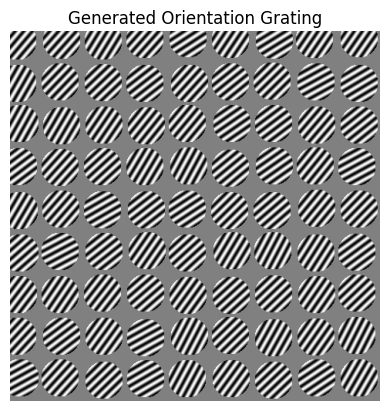

In [ ]:
stimulus = stimulus_generator.generate(scaling_factor=1.1)
model.compute_omega(stimulus)


In [ ]:
# Simulation Parameters
simulation_parameters = {
    "time_step": 0.01,
    "simulation_time": 1.0,
}

state, time_vector = model.simulate(simulation_parameters)

In [9]:
# Simulation Parameters
simulation_parameters = {
    "time_step": 0.01,
    "simulation_time": 1.0,
}

In [10]:
state, time_vector = model.simulate(simulation_parameters)